# Introduction

This is a very brief introduction to "classical" epidemic models. They are able to catch some of the most important features of the epidemics.

The simplest definition of epidemic dynamics considers the total population in the system as fixed, consisting of N individuals and ignores 
any other demographic process (migration, births, etc.).<br> 
One of the simplest two-state model is the <b>SIS</b> model, in which only two tranistions can occur:
- S + I $\to$ 2I, occurs when a susceptible individual interacts with an infectious individual and becames infected
- I $\to$ S, occurs when the infectious individual recovers from the disease and returns to the pool of susceptible individuals

The SIS model assumes that the disease does not confer immunity and individuals can be infected over and over again undergoing a cycle S $\to$ I $\to$ S.

Another basic model is the classical three-state <b>SIR</b> model, in which the following transitions can occur:
- S + I $\to$ 2I
- I $\to$ R
where the last one occurs whne an infectious individual recovers from a disease and is assumed to have aquired a permanent immunity or is removed (e.g. died).

In the SIS and SIR models, the infection and recovery process completely determine the epidemic evolution.
The I $\to$ R and I $\to$ S transitions occur spontaneously after a certain time the individuals spend fighting the disease or taking medical treatments.<br>
These kind of transitions do not depend on any interactions between individuals in the population.<br>
The S $\to$ I transition instead occcurs due to a <i>two-body</i> interaction. The probability estimation of S $\to$ I is thus the most crucial inference needed. 
It depends on several factors and hence we have to take into account different modeling approximations.<br>
In the absence of detailed data on human interactions, the most basic approach considers a homogenous mixing approximation, i.e. individuals <b>interact randomly</b> with each other. 

# Setup

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fmin, curve_fit

import matplotlib.pyplot as plt

# Interactive Jupyter
from ipywidgets import FloatProgress, FloatSlider, FloatRangeSlider, RadioButtons, Checkbox, HBox, VBox, interact, interactive
from IPython.display import display

In [2]:
# Ggplot Style
#plt.style.use('seaborn-dark')
plt.style.use('seaborn-darkgrid')
#plt.style.available

In [3]:
# Set Plot Dimensions (overall)
plt.rcParams['figure.figsize'] = (14, 9/16*14)
plt.rcParams['font.size'] = 14

# Classical Models

Although epidemic spreading is best described as a stochastic reaction-diffusion process (well known from statistical physics), the classical understanding<br>
of epidemic dynamics is based on taking the continuous-time limit of difference equations for the evolution of the average number of individuals<br>
in each compartment (susceptible, infected, ..).

The homogeneous mixing approximation is essentially equivalent to the <b>mean field approximation</b> in statistical physics.

Under this approximation, full information about the epidemics state is encoded in the total number of individuals $N^\alpha$ in the compartment $\alpha$ or<br>
in terms of the respective densities $\rho^\alpha = N^\alpha/N$, where $N$ is the population size.

The deterministic equations for the SIS and SIR process are obtained by applying the law of mass action:

$
\begin{align}
\frac{d\rho^I}{dt} & = \beta\,\rho^I\rho^S-\mu\,\rho^I\\
\frac{d\rho^S}{dt} & = -\beta\,\rho^I\rho^S+\chi\,\rho^I
\end{align}
$
where $\beta$ and $\mu$ are the transition rates for infection and recovery and:
- $\chi=\mu$ for the SIS process
- $\chi=0$ for the SIR process

The so-called force of infection is given by $\alpha=\beta\,\rho^I$.

The previous equations have to be complemented with the following normalization conditions:
- $\rho^R + \rho^I + \rho^S = 1$ for the SIR model
- $\rho^I + \rho^S = 1$ for the SIS model

In [4]:
# Parameters and initial conditions
beta = 0.0002
mu = 0.05
chi = 0. #SIR model
#chi = mu # SIS model

i0 = 10
s0 = 1000
N = s0+i0

print("R0={:5.5f}".format(N*beta/mu)) # CAVEAT: this is the actual R0, which is rescaled by N, the total population

R0=4.04000


In [5]:
# Epidemic equations
def epidemic(t, X, beta, mu, chi):
    """Epidemic equations."""
    i, s = X
    ip = beta*i*s - mu*i
    sp = -beta*i*s + chi*i
    return ip,sp

In [6]:
time_steps = 200
n_points = 200

# Integrate the equations on the time grid t
sol = solve_ivp(epidemic, (0,time_steps), (i0,s0), args=(beta, mu, chi), t_eval=np.linspace(0,time_steps,n_points))
i_fun, s_fun = sol.y.T[:,0], sol.y.T[:,1]
r_fun = (i0+s0) - i_fun - s_fun

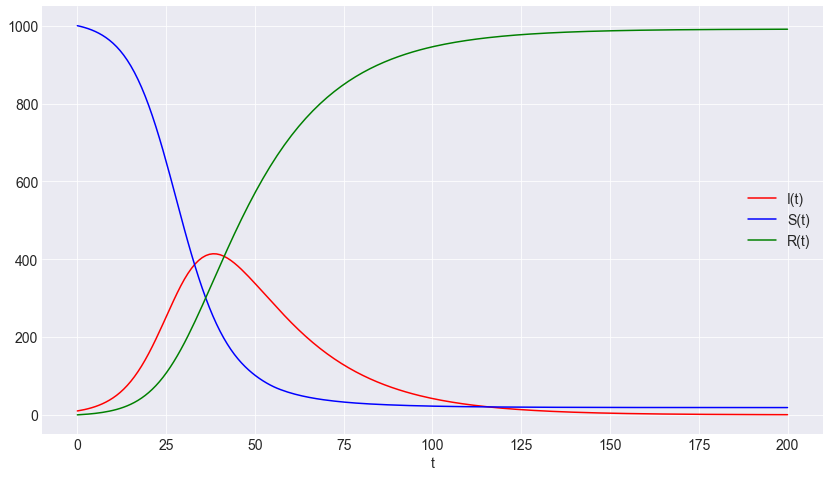

In [7]:
t = np.linspace(0, time_steps, i_fun.shape[0])
plt.plot(t,i_fun, c='red', label='I(t)');
plt.plot(t,s_fun, c='blue', label='S(t)');
plt.plot(t,r_fun, c='green', label='R(t)');
plt.xlabel('t');
plt.legend();

In [8]:
t_peak = np.where(i_fun==np.max(i_fun))

print("Infection peak --> t={:}\n% of infected at peak --> {:3.1f}%".format(t_peak[0][0],100*np.max(i_fun)/(s0+i0)))

Infection peak --> t=38
% of infected at peak --> 41.0%


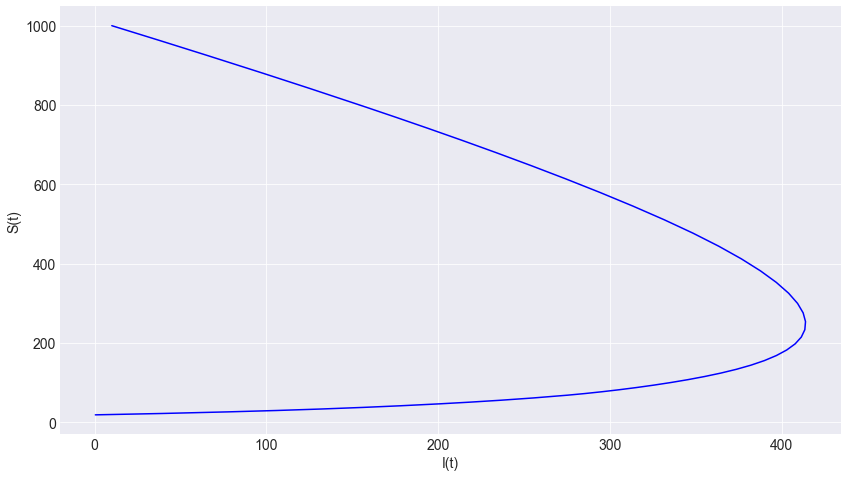

In [9]:
plt.plot(i_fun, s_fun, c='blue');
plt.xlabel('I(t)');
plt.ylabel('S(t)');

## Changing $\beta$

In [19]:
time_steps = 250
n_points = 300

beta_array = [0.00028, 0.000125, 0.0001]
i_fun_array = []
t_peak_array = []

for b in beta_array:
    sol = solve_ivp(epidemic, (0,time_steps), (i0,s0), args=(b, mu, chi), t_eval=np.linspace(0,time_steps,n_points))
    i_fun, s_fun = sol.y.T[:,0], sol.y.T[:,1]
    i_fun_array.append(i_fun)
    t_peak_array.append([np.where(i_fun==np.max(i_fun))[0][0], 100*np.max(i_fun)/N])

In [46]:
t_peak_array

[[32, 51.88979674062303], [78, 24.12578081880677], [104, 16.164749429060205]]

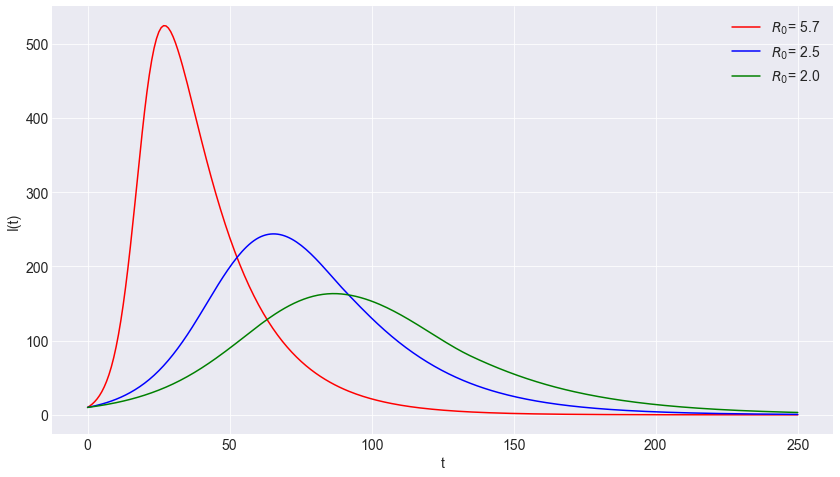

In [21]:
col_array = ['red','blue','green']

for f,c,r0 in zip(i_fun_array, col_array, [N*b/mu for b in beta_array]):
    t = np.linspace(0, time_steps, f.shape[0])
    plt.plot(t,f, c=c, label='$R_0$={:4.1f}'.format(r0));
plt.xlabel('t');
plt.ylabel('I(t)');
plt.legend();

In [47]:
for item in t_peak_array:
    print("Infection peak --> t={:}\n% of infected at peak --> {:3.1f}%".format(item[0],item[1]))

Infection peak --> t=32
% of infected at peak --> 51.9%
Infection peak --> t=78
% of infected at peak --> 24.1%
Infection peak --> t=104
% of infected at peak --> 16.2%


### Lombardy example

Let's assume $R_0=2.0$ without any <b>lockdown</b>

In [27]:
pop_lombardia = 10088484
_idx = 2

print("Infection peak reached in {} months with {:,} people infected".format(np.round(t_peak_array[_idx][0]/30), np.round(pop_lombardia*t_peak_array[_idx][1]/100)))

Infection peak reached in 3.0 months with 1,630,778.0 people infected


Let's assume $R_0=2.0$ with the virus around since January (1st).<br>
The first lockdowns began around 21 February 2020, covering eleven municipalities of the province of Lodi in Lombardy, and affecting around 50,000 people.<br>
Early on Sunday 8 March 2020, Italian Prime Minister Giuseppe Conte announced the expansion of the quarantine zone to cover much of northern Italy, affecting over sixteen million people.

In [28]:
# Sunday 8 March
t_lockdown_lombardy = 31+28+8

print("{:,} people infected".format(round(pop_lombardia*i_fun_array[_idx][t_lockdown_lombardy]/N)))

1,075,304.0 people infected


## Check for Exponential 

The exponential phase strictly holds only in the very early phase of the epidemics.

Taking into account the limit $\rho^I\simeq0$, one can linearize the epidemic equations (for both SIS and SIR models) obtaining the simple equations:

$
\begin{align}
\frac{d\rho^I}{dt} & \simeq \left(\beta -\mu\right)\,\rho^I
\end{align}
$

whose solution is:

$
\begin{align}
\rho^I(t)\simeq \rho^I(0)\,e^{(\beta-\mu)t}
\end{align}
$

The number of infectious individuals grows exponentially if:

$
\begin{align}
\beta-\mu>0 \Rightarrow R_0=\frac{\beta}{\mu}>1
\end{align}
$

where $R_0$ is the <b>basic reproduction number</b>.

In [22]:
def fit_exp_fun(x,a,b,c):
    return a * np.exp(b * x) + c

In [56]:
_idx = 0
idx_star = 20
data = i_fun_array[_idx][0:idx_star]
t = range(1,idx_star+1)


popt, pcov = curve_fit(fit_exp_fun, t, data)

In [57]:
a, b, c = popt

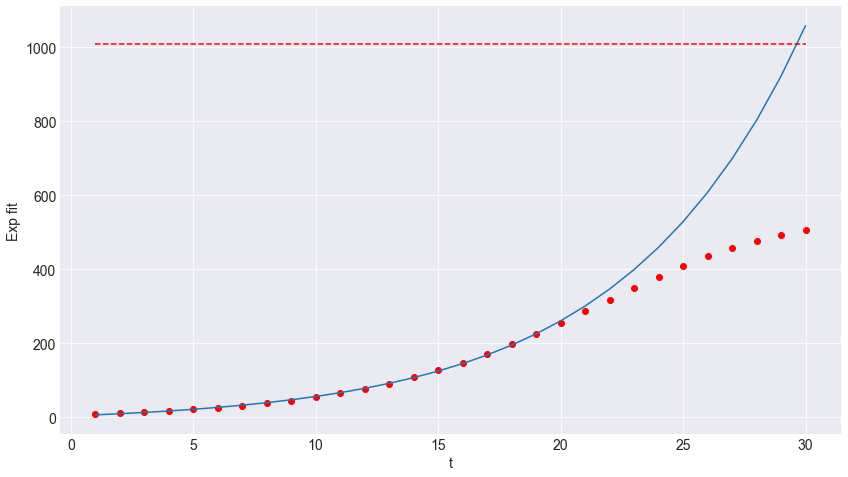

In [60]:
idx_end = 30 
t_period = range(1,idx_end+1)

plt.plot(t_period, fit_exp_fun(t_period, a, b, c));
plt.scatter(t_period, i_fun_array[_idx][0:idx_end], c='r');
plt.plot(t_period,np.repeat(N,len(t_period)),'--',c='r');
plt.xlabel('t');
plt.ylabel('Exp fit');

## $\beta=\beta(t)$

In this section we study the dynamical behaviour by considering $\beta$ as a function of time. 

In [17]:
# Parameters and initial conditions
mu = 0.05
chi = 0. #SIR model
#chi = mu # SIS model

beta_0 = 0.0005
i0 = 10
s0 = 1000
N = s0+i0

print("R0={:5.5f}".format(N*beta/mu)) # CAVEAT: R0 rescaled by N, the total population

R0=10.10000


In the following we assume a linear decreasing beta:
- $\beta(t) = -\alpha\cdot t$

In [18]:
# Epidemic equations
def epidemic(t, X, alpha, mu, chi):
    """Epidemic equations."""
    i, s, beta = X
    betap = -1*alpha
    ip = beta*i*s - mu*i
    sp = -beta*i*s + chi*i
    return ip,sp,betap

In [19]:
time_steps = 100
n_points = 200

alpha = 0.00002

# Integrate the equations on the time grid t
sol = solve_ivp(epidemic, (0,time_steps), (i0,s0,beta_0), args=(alpha, mu, chi), t_eval=np.linspace(0,time_steps,n_points))
i_fun, s_fun = sol.y.T[:,0], sol.y.T[:,1]

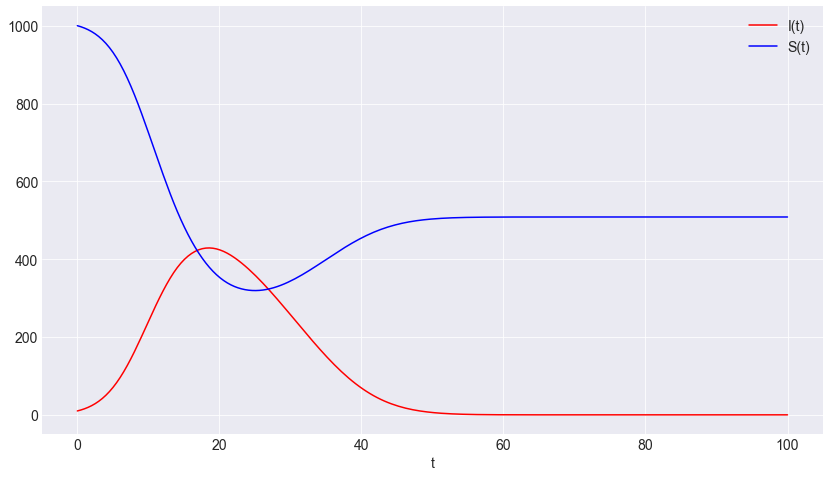

In [20]:
t = np.linspace(0, time_steps, i_fun.shape[0])
plt.plot(t,i_fun, c='red', label='I(t)');
plt.plot(t,s_fun, c='blue', label='S(t)');
plt.xlabel('t');
plt.legend();

## Interactive

In [28]:
beta_slider = FloatSlider(value=0.0002,
                          min=0.00001,max=0.001,
                          step=0.00005,
                          description='beta:',
                          disabled=False,continuous_update=False,orientation='horizontal',
                          readout=True,readout_format='.5f')

mu_slider = FloatSlider(value=0.05,
                          min=0.001,max=0.1,
                          step=0.001,
                          description='mu:',
                          disabled=False,continuous_update=False,orientation='horizontal',
                          readout=True,readout_format='.3f')

model_slider = RadioButtons(
    options=['SIS', 'SIR'],
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description='model:',
    disabled=False
)

def interactive_fun(beta_in, mu_in, model_in):
    if model_in=='SIR':
        chi = 0. #SIR model
    else:
        chi = mu_in # SIS model
    i0 = 10
    s0 = 1000
    N = s0+i0
    
    # Integrate the equations on the time grid t
    sol = solve_ivp(epidemic, (0,time_steps), (i0,s0), args=(beta_in, mu_in, chi), t_eval=np.linspace(0,time_steps,n_points))
    i_fun, s_fun = sol.y.T[:,0], sol.y.T[:,1]
    
    t = np.linspace(0, time_steps, i_fun.shape[0])
    plt.plot(t,i_fun, c='red', label='I(t)');
    plt.plot(t,s_fun, c='blue', label='S(t)');
    if model_in=='SIR':
        r_fun = N - i_fun - s_fun
        plt.plot(t,r_fun, c='green', label='R(t)');
    plt.xlabel('t');
    plt.legend();
    
interact(interactive_fun, beta_in=beta_slider, mu_in=mu_slider, model_in=model_slider);

interactive(children=(FloatSlider(value=0.0002, continuous_update=False, description='beta:', max=0.001, min=1…

# Bibliography

- ["Epidemic processes in complex networks", Romualdo Pastor-Satorras et al](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.87.925)

***